In [1]:
import pip

package_names = ['scorecardpy', 'awswrangler', 'sagemaker'] 
pip.main(['install'] + package_names + ['--upgrade'])

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


0

In [2]:
# Nativos
from dateutil.relativedelta import relativedelta
from time import gmtime, strftime
from datetime import datetime
import random as rn
import joblib
import json
import sys
import os
import gc

#nube
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker import get_execution_role
import awswrangler as wr
import sagemaker
import boto3

#calculo
import pandas as pd
import numpy as np
import scipy

#grafico
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="whitegrid")

#Interacciones con output
import warnings
warnings.filterwarnings("ignore")
# warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

gc.collect()
# MODELS
#from lightgbm import LGBMClassifier

BASE_DIR = os.path.dirname(os.getcwd())
if BASE_DIR not in sys.path: sys.path.append(BASE_DIR)
#import scorecardpy as sc


SEED = 29082013
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
rn.seed(SEED)

from setup import *

////////////////////////////////////////////////// 

path_container_input:  /opt/ml/processing/input
path_container_output:  /opt/ml/processing/output
path_container_utils:  /opt/ml/processing/input/utils
path_container_universo:  /opt/ml/processing/input/HM_UNIVERSO_PROPENSION_DESEMBOLSO_BPE


### COnfig

In [3]:
print("bucket: ", bucket)
print("region: ", region)
print("now: ", now)
print("target: ", target)

bucket:  sagemaker-us-east-1-058528764918
region:  us-east-1
now:  2021-09-15 05:02:47.734934
target:  target_desembolso_f2m_mayor_30_menor_180


### RUtas

In [4]:
print('uri_output: \n', uri_output)
print("select: \n", select)
print("woe: \n", woe)
print("correlation: \n", correlation)

uri_output: 
 s3://sagemaker-us-east-1-058528764918/vpc/propension/output3
select: 
 s3://sagemaker-us-east-1-058528764918/vpc/propension/output3/seleccion_variables_target_desembolso_f2m_mayor_30_menor_180_clasif_normal.csv
woe: 
 s3://sagemaker-us-east-1-058528764918/vpc/propension/output3/woe_target_desembolso_f2m_mayor_30_menor_180_clasif_normal.json
correlation: 
 s3://sagemaker-us-east-1-058528764918/vpc/propension/output3/train_correlation_clasif_normal.csv


### Correlation

In [5]:
matriz_corr = wr.s3.read_csv(
    correlation, 
    sep=','
)
matriz_corr.index = matriz_corr.columns
matriz_corr.head()

,target_desembolso_f2m_mayor_30_menor_180,flg_registro_ibk,facturacion_periodo_mnt,facturacion_prom_ult3m_mnt,facturacion_prom_ult6m_mnt,facturacion_prom_ult9m_mnt,deuda_agrar_prom_ult3m_mnt,deuda_agrar_prom_ult6m_mnt,deuda_agrar_prom_ult9m_mnt,deuda_sf_prom_ult3m,deuda_sf_prom_ult6m,deuda_sf_prom_ult9m,tend_facturacion_ult_trim_mnt,tend_facturacion_ult_mes_mnt,tend_deuda_agrar_ult_trim_mnt,tend_deuda_agrar_ult_mes_mnt,tend_deuda_sf_ult_trim_mnt,tend_deuda_sf_ult_mes_mnt,nro_entidades_financ_cnt,nro_entid_financ_prom_ult3m_cnt,nro_entid_financ_prom_ult6m_cnt,nro_entid_financ_prom_ult9m_cnt,nro_entid_mayor_actual_ult3m_cnt,nro_entid_diff_actual_ult2m,flg_cambio_banca_ult3m,flg_cambio_banca_ult6m,flg_cambio_banca_ult9m,cambio_banca_ult3m_cnt,cambio_banca_ult6m_cnt,cambio_banca_ult9m_cnt,flg_cambio_region_ult3m,flg_cambio_region_ult6m,flg_cambio_region_ult9m,flg_cambio_segmento_ult3m,flg_cambio_segmento_ult6m,flg_cambio_segmento_ult9m,saldo_ajustado_ult_rcc,max_saldo_ajustado_promedio_u3m,max_saldo_ajustado_promedio_u6m,max_saldo_ajustado_promedio_u9m,sum_saldo_ajustado_promedio_u3m,sum_saldo_ajustado_promedio_u6m,sum_saldo_ajustado_promedio_u9m,nro_entidades_9_meses_o_mas_con_saldo_ajustado,nro_entidades_8_meses_o_mas_con_saldo_ajustado,nro_entidades_7_meses_o_mas_con_saldo_ajustado,nro_entidades_6_meses_o_mas_con_saldo_ajustado,nro_entidades_5_meses_o_mas_con_saldo_ajustado,nro_entidades_4_meses_o_mas_con_saldo_ajustado,nro_entidades_3_meses_o_mas_con_saldo_ajustado,nro_entidades_2_meses_o_mas_con_saldo_ajustado,nro_entidades_1_meses_o_mas_con_saldo_ajustado,nro_entidades_ya_no_tiene_saldo_ajustado_u9m,nro_entidades_ya_no_tiene_saldo_ajustado_u6m,nro_entidades_ya_no_tiene_saldo_ajustado_u3m,nro_entidades_termino_prestamo_u9m,nro_entidades_termino_prestamo_u6m,nro_entidades_termino_prestamo_u3m,nro_entidades_recien_3_meses_con_saldo_ajustado_u9m,nro_entidades_recien_2_meses_con_saldo_ajustado_u9m,nro_entidades_recien_1_mes_con_saldo_ajustado_u9m,nro_entidades_recien_3_meses_con_saldo_ajustado_u6m,nro_entidades_recien_2_meses_con_saldo_ajustado_u6m,nro_entidades_recien_1_mes_con_saldo_ajustado_u6m,ultima_variacion_saldo_ajustado,variacion_neta_saldo_ajustado_u3m,variacion_neta_saldo_ajustado_u6m,monto_adquirido_ult_rcc,monto_adquirido_u3m,monto_adquirido_u6m,monto_pagado_ult_rcc,monto_pagado_u3m,monto_pagado_u6m,target_desembolso_f2m_f3m_mayor_10_menor_180,target_desembolso_f2m_f3m_mayor_30_menor_180,target_desembolso_f2m_mayor_10_menor_180,target_monto_variacion_f2m,target_monto_variacion_f3m,nro_variacion_up10k_low30k_positiva_ult_rcc,nro_varacion_up10k_low30k_positiva_u3m,nro_varacion_up10k_low30k_positiva_u6m,nro_variacion_up10k_low30k_negativa_ult_rcc,nro_varacion_up10k_low30k_negativa_u3m,nro_varacion_up10k_low30k_negativa_u6m,nro_variacion_up180k_positiva_ult_rcc,nro_variacion_up180k_positiva_u3m,nro_variacion_up180k_positiva_u6m,nro_variacion_up180k_negativa_ult_rcc,nro_variacion_up180k_negativa_u3m,nro_variacion_up180k_negativa_u6m,saldo_col_vig,saldo_col_vig_ibk,saldo_col_vig_otros_bancos,saldo_col_vig_cajas,sow_ibk,sow_otros_bancos,sow_cajas,nro_tipo_entidad,nro_entidades,nroregs_garantia_reactiva_bcos,nroregs_reactiva_bcos,nroregs_inmobiliario_bcos,nroregs_garantias_bcos,nroregs_reprogramados_bcos,nroregs_cred_castigados_bcos,nroregs_garantia_fae_bcos,nroregs_fae_bcos,nroregs_coloc_directas_bcos,nroregs_coloc_indirectas_bcos,nroregs_garantia_reactiva_cajas,nroregs_reactiva_cajas,nroregs_inmobiliario_cajas,nroregs_garantias_cajas,nroregs_reprogramados_cajas,nroregs_cred_castigados_cajas,nroregs_garantia_fae_cajas,nroregs_fae_cajas,nroregs_coloc_directas_cajas,nroregs_coloc_indirectas_cajas,flg_clasif_normal,flg_clasif_cpp,flg_clasif_deficiente,flg_clasif_dudosa,flg_clasif_perdida,saldo_vig_con_lm,saldo_vig_sin_lm,saldo_venc_con_lm,saldo_venc_sin_lm,saldo_garantia_reactiva,saldo_reactiva,saldo_inmobiliario,saldo_garantias,saldo_reprogramados,saldo_creditos_castigados,saldo_garantia_fae,saldo_fae,saldo_coloc_directas,sal

In [6]:
top_correlacion = pd.DataFrame(matriz_corr[target].abs().sort_values(ascending=False))
top_correlacion.style.background_gradient(
    cmap='coolwarm', axis=None
).set_precision(5)

,target_desembolso_f2m_mayor_30_menor_180
target_desembolso_f2m_mayor_30_menor_180,1.00000
target_desembolso_f2m_f3m_mayor_30_menor_180,0.70316
target_desembolso_f2m_mayor_10_menor_180,0.70143
target_desembolso_f2m_f3m_mayor_10_menor_180,0.49362
target_monto_variacion_f2m,0.29547
monto_pagado_u6m,0.11265
monto_pagado_u3m,0.10666
monto_pagado_ult_rcc,0.08990
nro_entidades_ya_no_tiene_saldo_ajustado_u3m,0.08632
nro_entidades_ya_no_tiene_saldo_ajustado_u9m,0.08360


In [7]:
dict_correlation = top_correlacion.iloc[:].to_dict()[target]

### Selección iv / probabilidad

In [8]:
seleccion = wr.s3.read_csv(
    select, 
    sep=','
)
seleccion.head(20)

,ranking_iv,ranking_prob,variable,max_prob,iv,woe
0,0,7,monto_pagado_u6m,0.075520,0.503085,1.086085
1,1,3,monto_pagado_u3m,0.083135,0.469249,1.190431
2,2,5,variacion_neta_saldo_ajustado_u6m,0.079725,0.358557,1.144832
3,3,8,variacion_neta_saldo_ajustado_u3m,0.074675,0.352003,1.073919
4,4,9,ultima_variacion_saldo_ajustado,0.071010,0.339368,1.019646
5,5,10,monto_pagado_ult_rcc,0.070741,0.323823,1.015555
6,6,6,nro_entidades_ya_no_tiene_saldo_ajustado_u3m,0.079045,0.259930,1.135520
7,7,35,sum_saldo_ajustado_promedio_u9m,0.049299,0.236978,0.631629
8,8,1,nro_entidades_ya_no_tiene_saldo_ajustado_u6m,0.087315,0.233858,1.244053
9,9,0,nro_entidades_ya_no_tiene_saldo_ajustado_u9m,0.102088,0.228282,1.416681


In [9]:
seleccion['correlation_spearman'] = seleccion['variable'].apply(lambda _: dict_correlation.get(_, 100))
seleccion = seleccion.sort_values(
    by=['correlation_spearman'], ascending=False).reset_index(drop=True).reset_index().rename(columns={'index': 'ranking_corr'})

seleccion['ranking'] = seleccion[['ranking_prob', 'ranking_iv', 'ranking_corr']].mean(axis=1)
seleccion = seleccion.sort_values(by=['ranking'], ascending=True).reset_index(drop=True)

seleccion.head(30)

,ranking_corr,ranking_iv,ranking_prob,variable,max_prob,iv,woe,correlation_spearman,ranking
0,5,1,3,monto_pagado_u3m,0.083135,0.469249,1.190431,0.106659,3.000000
1,4,0,7,monto_pagado_u6m,0.075520,0.503085,1.086085,0.112650,3.666667
2,8,9,0,nro_entidades_ya_no_tiene_saldo_ajustado_u9m,0.102088,0.228282,1.416681,0.083597,5.666667
3,9,8,1,nro_entidades_ya_no_tiene_saldo_ajustado_u6m,0.087315,0.233858,1.244053,0.082792,6.000000
4,7,6,6,nro_entidades_ya_no_tiene_saldo_ajustado_u3m,0.079045,0.259930,1.135520,0.086323,6.333333
5,6,5,10,monto_pagado_ult_rcc,0.070741,0.323823,1.015555,0.089903,7.000000
6,18,2,5,variacion_neta_saldo_ajustado_u6m,0.079725,0.358557,1.144832,0.061814,8.333333
7,13,4,9,ultima_variacion_saldo_ajustado,0.071010,0.339368,1.019646,0.071948,8.666667
8,20,3,8,variacion_neta_saldo_ajustado_u3m,0.074675,0.352003,1.073919,0.061235,10.333333
9,22,24,2,nro_varacion_up10k_low30k_negativa_u6m,0.084759,0.112540,1.211542,0.060005,16.000000


In [10]:
def corr_detail(df_corr, min_value=0.85, show_detail=True, col_target='target'):
    
    corr_taret = df_corr[col_target].sort_values(ascending=False).apply(lambda _: abs(_)).sort_values(ascending=False)
    
    from itertools import combinations
    def add_dicc(key, val, num, dicc):
        if key in dicc:
            dicc[key].append((val, num))
        else:
            dicc[key] = [(val, num)]
        
    set_unique, list_detected = set(), []
    dicc_detected = {}
    

    for cols in combinations(list(df_corr.columns), 2):
        corr_columns = np.fabs(df_corr[cols[0]][cols[1]])
        
        if corr_columns >= min_value:
            set_unique.update(cols)
            list_detected.extend(list(cols))
            add_dicc(cols[0], cols[1], corr_columns, dicc_detected)
            add_dicc(cols[1], cols[0], corr_columns, dicc_detected)        
            
    print("ANALISIS CORRELACION ENTRE COLUMNAS :")
    columnas_aparece = []
    cols_del = []
    for colc, cant in sorted(
        [(col, list_detected.count(col)) for col in set_unique], key=lambda _: _[1], reverse=True):
        
        if colc not in columnas_aparece:
            print("/"*30)
            print("-> ", colc, ' :::: ',cant, ' ///// ', corr_taret[colc])
            columnas_aparece.append(colc)
            if show_detail:
                for _ in dicc_detected[colc]:
                    print(" "*10, *_, '///// ',  corr_taret[_[0]])
                    #columnas_aparece.append(_[0])
                    
                    if corr_taret[_[0]] <= corr_taret[colc]:
                        cols_del.append(_[0])
                    else:
                        cols_del.append(colc)
                    
    del dicc_detected
    del list_detected
    del set_unique
    return list(set(cols_del))

In [11]:
top_30 = list(seleccion.head(150)['variable'])

In [12]:
corr = matriz_corr.reset_index()
corr = corr[corr['index'].isin(top_30)]
corr = corr[['index', target] + top_30].set_index('index')
corr.shape

(150, 151)

In [13]:
#corr

In [14]:
list_del = corr_detail(corr, min_value=0.8, show_detail=True, col_target=target)
len(list_del)

ANALISIS CORRELACION ENTRE COLUMNAS :
//////////////////////////////
->  porc_coloc_direct_vig_cajas  ::::  13  /////  0.015300243720277119
           nroregs_coloc_directas_bcos 0.8893376982780709 /////  0.039489975916999716
           saldo_coloc_direct_vig_no_ibk 0.832207451303139 /////  0.039317167928563684
           tendencia_nro_coloc_direct_bancos 0.8636402196336261 /////  0.020283896238182025
           saldo_coloc_direct_vig_bcos 0.8859494499303976 /////  0.035805021475983474
           sow_otros_bancos 0.8002461523058944 /////  0.026411662588060863
           porc_coloc_direct_vig_no_ibk 0.9127453229993244 /////  0.0213603929364272
           porc_coloc_direct_vig_bcos 0.9867092496288395 /////  0.016987384137238718
           sow_cajas 0.9247423820416988 /////  0.013992563404238113
           prom_coloc_direct_cajas_u3m 0.8163455021105595 /////  0.01688481719524061
           saldo_coloc_direct_vig_cajas 0.8216093045620663 /////  0.012565840738487363
           saldo_vig_con

83

In [15]:
seleccionadas = [col for col in top_30 if col not in list_del]
print(seleccionadas)

['monto_pagado_u6m', 'nro_entidades_ya_no_tiene_saldo_ajustado_u9m', 'nro_entidades_ya_no_tiene_saldo_ajustado_u3m', 'variacion_neta_saldo_ajustado_u6m', 'variacion_neta_saldo_ajustado_u3m', 'nro_varacion_up10k_low30k_negativa_u6m', 'sum_saldo_ajustado_promedio_u9m', 'nro_entidades', 'nro_varacion_up10k_low30k_negativa_u3m', 'nro_entid_financ_prom_ult9m_cnt', 'nro_entidades_termino_prestamo_u9m', 'nroregs_coloc_directas_bcos', 'saldo_coloc_direct_tc', 'monto_adquirido_u6m', 'nro_variacion_up10k_low30k_negativa_ult_rcc', 'saldo_coloc_direct_vig_cmpt', 'nroregs_reprogramados_bcos', 'tendencia_saldo_coloc_direct_vig_venc', 'tend_deuda_agrar_ult_mes_mnt', 'saldo_col_vig_otros_bancos', 'saldo_garantia_fae', 'nroregs_garantias_bcos', 'tendencia_nro_entidades', 'saldo_col_vig_ibk', 'nro_entidades_termino_prestamo_u3m', 'nro_varacion_up10k_low30k_positiva_u6m', 'nroregs_garantia_fae_bcos', 'ciiu_cd_encoder_target_desembolso_f2m_mayor_30_menor_180', 'prom_reprog_u3m', 'tendencia_cobertura_gar_a

In [16]:
len(seleccionadas)

67

### Seleccionadas

In [17]:
seleccion[seleccion['variable'].isin(seleccionadas)].reset_index(drop=True)

,ranking_corr,ranking_iv,ranking_prob,variable,max_prob,iv,woe,correlation_spearman,ranking
0,4,0,7,monto_pagado_u6m,0.075520,0.503085,1.086085,0.112650,3.666667
1,8,9,0,nro_entidades_ya_no_tiene_saldo_ajustado_u9m,0.102088,0.228282,1.416681,0.083597,5.666667
2,7,6,6,nro_entidades_ya_no_tiene_saldo_ajustado_u3m,0.079045,0.259930,1.135520,0.086323,6.333333
3,18,2,5,variacion_neta_saldo_ajustado_u6m,0.079725,0.358557,1.144832,0.061814,8.333333
4,20,3,8,variacion_neta_saldo_ajustado_u3m,0.074675,0.352003,1.073919,0.061235,10.333333
5,22,24,2,nro_varacion_up10k_low30k_negativa_u6m,0.084759,0.112540,1.211542,0.060005,16.000000
6,10,7,35,sum_saldo_ajustado_promedio_u9m,0.049299,0.236978,0.631629,0.076227,17.333333
7,27,27,11,nro_entidades,0.067426,0.104320,0.963996,0.053975,21.666667
8,26,40,4,nro_varacion_up10k_low30k_negativa_u3m,0.081275,0.083197,1.165771,0.054598,23.333333
9,30,28,41,nro_entid_financ_prom_ult9m_cnt,0.047887,0.104068,0.601078,0.051841,33.000000


### WOE BIN

In [18]:
woe_df = pd.read_json(woe)
woe_df.head()

,facturacion_prom_ult3m_mnt,nro_entidades_6_meses_o_mas_con_saldo_ajustado,saldo_coloc_direct_factoring,percent_sobregavanc,region_fin_val_,saldo_garantias,saldo_garant_hipoteca,nro_entidades_2_meses_o_mas_con_saldo_ajustado,porc_coloc_indirect_bcos,cobert_garpref_over_coloc_direct_vig,tendencia_atraso_coloc_direct,region_fin_val_SUR,deuda_sf_prom_ult3m,tendencia_cobertura_gar_autohipo_over_coloc_direct_vig_venc,tendencia_coloc_indirectas,saldo_coloc_direct_comex,tend_deuda_agrar_ult_mes_mnt,nro_variacion_up10k_low30k_positiva_ult_rcc,nro_entid_financ_prom_ult6m_cnt,flg_clasif_dudosa,nro_entid_financ_prom_ult9m_cnt,maxdias_atraso_coloc_direct_judic,nro_entidades_recien_3_meses_con_saldo_ajustado_u9m,nro_variacion_up180k_positiva_ult_rcc,tendencia_factoring,maxdias_atraso_sobreg_avance,variacion_neta_saldo_ajustado_u3m,tend_deuda_sf_ult_mes_mnt,nro_variacion_up180k_negativa_ult_rcc,sow_ibk,porc_coloc_indirect_cmpt,tendencia_nro_coloc_direct_cajas,nro_variacion_up180k_negativa_u6m,porc_coloc_indirect_ibk,prom_coloc_direct_venc_u3m,saldo_coloc_direct_sobregavanc,departamento_fin_val_encoder_target_desembolso_f2m_mayor_30_menor_180,monto_pagado_u3m,sow_otros_bancos,saldo_coloc_indirect_cajas,saldo_garant_autoliquid,nroregs_fae_bcos,flg_cambio_segmento_ult3m,saldo_coloc_direct_leasing,saldo_inmobiliario,saldo_col_vig_otros_bancos,variacion_neta_saldo_ajustado_u6m,saldo_garantia_fae,saldo_coloc_direct_refinanc,nroregs_fae_cajas,maxdias_atraso_dctos,monto_pagado_u6m,region_fin_val_NORTE,deuda_sf_prom_ult9m,flg_clasif_normal,saldo_coloc_indirect_no_ibk,cobert_garpref_over_coloc_direct,flg_clasif_cpp,percent_leasing,monto_adquirido_u3m,maxdias_atraso_coloc_direct_vig,flg_cambio_region_ult9m,saldo_vig_con_lm,nro_varacion_up10k_low30k_positiva_u6m,nro_entidades_recien_3_meses_con_saldo_ajustado_u6m,saldo_coloc_direct_vig_cajas,nro_variacion_up180k_positiva_u6m,tendencia_cobertura_gar_pref_over_coloc_direct_vig_venc,percent_tc,nroregs_reprogramados_cajas,target_monto_variacion_f2m,saldo_coloc_direct_tc,max_saldo_ajustado_promedio_u3m,tendencia_reprogramados,monto_adquirido_u6m,saldo_col_vig_ibk,maxdias_atraso_reprog,tendencia_saldo_comex,saldo_coloc_direct_vig_bcos,prom_atraso_coloc_direct_u3m,nroregs_reactiva_cajas,tendencia_saldo_coloc_direct_vig_ibk,porc_coloc_direct_vig_cajas,nro_variacion_up180k_positiva_u3m,nro_entidades,flg_cambio_banca_ult9m,cobert_garpref_over_coloc_direct_vig_y_venc,monto_adquirido_ult_rcc,nroregs_garantia_fae_bcos,prom_reprog_u3m,maxdias_atraso_leasing,nroregs_cred_castigados_cajas,tendencia_garantias,nroregs_garantias_cajas,prom_comex_u3m,flg_cambio_segmento_ult6m,saldo_coloc_indirect_bcos,nroregs_coloc_directas_bcos,flg_cambio_region_ult3m,saldo_coloc_direct_vig_ibk,tend_deuda_agrar_ult_trim_mnt,maxdias_atraso_tc,nroregs_coloc_indirectas_bcos,flg_clasif_perdida,ultima_variacion_saldo_ajustado,saldo_garant_otros,cambio_banca_ult9m_cnt,region_fin_val_cat_encoder_target_desembolso_f2m_mayor_30_menor_180,saldo_coloc_direct_vig,facturacion_prom_ult6m_mnt,cambio_banca_ult6m_cnt,sum_saldo_ajustado_promedio_u6m,nro_entidades_recien_2_meses_con_saldo_ajustado_u9m,deuda_agrar_prom_ult3m_mnt,target_monto_variacion_f3m,maxdias_atraso_factoring,prom_coloc_direct_ibk_u3m,maxdias_atraso_comex,porc_coloc_direct_vig_no_ibk,deuda_sf_prom_ult6m,nro_entidades_5_meses_o_mas_con_saldo_ajustado,target_desembolso_f2m_f3m_mayor_30_menor_180,nro_entidades_ya_no_tiene_saldo_ajustado_u6m,prom_inmobiliario_u3m,tendencia_inmobiliario,tendencia_nro_coloc_direct_bancos,saldo_garant_preferidas,saldo_ajustado_ult_rcc,maxdias_atraso_imb,flg_registro_ibk,saldo_coloc_indirect_cmpt,maxdias_atraso_fae,nro_variacion_up10k_low30k_negativa_ult_rcc,nro_entid_diff_actual_ult2m,nro_entidades_7_meses_o_mas_con_saldo_ajustado,sow_cajas,cobert_garhipauto_over_coloc_direct_vig_y_venc,deuda_agrar_prom_ult9m_mnt,saldo_garantia_reactiva,tendencia_saldo_vig_lm,porc_coloc_indirect_no_ibk,saldo_coloc_direct_vig_no_ibk,prom_atraso_coloc_direct_vig_u3m,porc_coloc_i

## ANALISIS POR COLUMNA

In [19]:
col =  'sum_saldo_ajustado_promedio_u9m'

In [20]:
woe_df[col].to_dict()['bin']

{'0': '[-inf,5000.0)',
 '1': '[5000.0,30000.0)',
 '2': '[30000.0,60000.0)',
 '3': '[60000.0,100000.0)',
 '4': '[100000.0,inf)'}

In [21]:
def get_cortes_ultima_variacion_saldo_ajustado(val):
    if val < -4200.0:
        return '[-inf,-4200.0)'
    elif val < -2000.0:
        return '[-4200.0,-2000.0)'
    elif val < -1000.0:
        return '[-2000.0,-1000.0)'
    elif val < 5200.0:
        return '[-1000.0,5200.0)'
    else:
        return '[5200.0,inf)'

#df[col + '_cortes'] = df[col].apply(get_cortes_1)

In [22]:
woe_dict = pd.read_json(woe).to_dict()
len(woe_dict)

228

In [23]:
woe_dict = {k:pd.DataFrame(v) for k, v in woe_dict.items() if k in seleccionadas}

In [32]:
woe_dict = {
    k: v for k, v in sorted(
        woe_dict.items(), 
        key=lambda _: _[1]['total_iv'].max(), 
        reverse=True
    )
}

for k, v in woe_dict.items():
    display(v)

,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,monto_pagado_u6m,"[-inf,4000.0)",1260875,0.427516,1246523,14352,0.011383,-0.873305,0.220904,0.503085,4000.0,False
1,monto_pagado_u6m,"[4000.0,11000.0)",701981,0.238016,687540,14441,0.020572,-0.272130,0.015531,0.503085,11000.0,False
2,monto_pagado_u6m,"[11000.0,33000.0)",651027,0.220739,626012,25015,0.038424,0.371025,0.036353,0.503085,33000.0,False
3,monto_pagado_u6m,"[33000.0,inf)",335421,0.113729,310090,25331,0.075520,1.086085,0.230297,0.503085,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,variacion_neta_saldo_ajustado_u6m,"[-inf,-32000.0)",197654,0.067017,181896,15758,0.079725,1.144832,0.155403,0.358557,-32000.0,False
1,variacion_neta_saldo_ajustado_u6m,"[-32000.0,-12000.0)",390832,0.132517,373500,17332,0.044346,0.520555,0.046264,0.358557,-12000.0,False
2,variacion_neta_saldo_ajustado_u6m,"[-12000.0,-6000.0)",362247,0.122825,352399,9848,0.027186,0.013423,0.000022,0.358557,-6000.0,False
3,variacion_neta_saldo_ajustado_u6m,"[-6000.0,10000.0)",1536564,0.520992,1514282,22282,0.014501,-0.627999,0.154512,0.358557,10000.0,False
4,variacion_neta_saldo_ajustado_u6m,"[10000.0,inf)",462007,0.156650,448088,13919,0.030127,0.119184,0.002355,0.358557,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,variacion_neta_saldo_ajustado_u3m,"[-inf,-18000.0)",219739,0.074505,203330,16409,0.074675,1.073919,0.146591,0.352003,-18000.0,False
1,variacion_neta_saldo_ajustado_u3m,"[-18000.0,-7000.0)",380607,0.129050,363715,16892,0.044382,0.521389,0.045217,0.352003,-7000.0,False
2,variacion_neta_saldo_ajustado_u3m,"[-7000.0,-3000.0)",494139,0.167544,481840,12299,0.024890,-0.077175,0.000962,0.352003,-3000.0,False
3,variacion_neta_saldo_ajustado_u3m,"[-3000.0,8000.0)",1471511,0.498935,1450456,21055,0.014308,-0.641576,0.153533,0.352003,8000.0,False
4,variacion_neta_saldo_ajustado_u3m,"[8000.0,inf)",383308,0.129966,370824,12484,0.032569,0.199639,0.005699,0.352003,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,nro_entidades_ya_no_tiene_saldo_ajustado_u3m,"[-inf,1.0)",2014886,0.683173,1978545,36341,0.018036,-0.406251,0.093496,0.25993,1.0,False
1,nro_entidades_ya_no_tiene_saldo_ajustado_u3m,"[1.0,2.0)",785034,0.266176,754044,30990,0.039476,0.399133,0.051437,0.25993,2.0,False
2,nro_entidades_ya_no_tiene_saldo_ajustado_u3m,"[2.0,inf)",149384,0.050651,137576,11808,0.079045,1.135520,0.114997,0.25993,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,sum_saldo_ajustado_promedio_u9m,"[-inf,5000.0)",410910,0.139324,407077,3833,0.009328,-1.074436,0.100349,0.236978,5000.0,False
1,sum_saldo_ajustado_promedio_u9m,"[5000.0,30000.0)",941299,0.319160,923939,17360,0.018443,-0.383558,0.039334,0.236978,30000.0,False
2,sum_saldo_ajustado_promedio_u9m,"[30000.0,60000.0)",793787,0.269144,771005,22782,0.028700,0.069195,0.001332,0.236978,60000.0,False
3,sum_saldo_ajustado_promedio_u9m,"[60000.0,100000.0)",397095,0.134640,381957,15138,0.038122,0.362819,0.021118,0.236978,100000.0,False
4,sum_saldo_ajustado_promedio_u9m,"[100000.0,inf)",406213,0.137732,386187,20026,0.049299,0.631629,0.074846,0.236978,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,nro_entidades_ya_no_tiene_saldo_ajustado_u9m,"[-inf,1.0)",2308509,0.782730,2262357,46152,0.019992,-0.301303,0.061784,0.228282,1.0,False
1,nro_entidades_ya_no_tiene_saldo_ajustado_u9m,"[1.0,2.0)",579299,0.196419,552590,26709,0.046106,0.561303,0.081370,0.228282,2.0,False
2,nro_entidades_ya_no_tiene_saldo_ajustado_u9m,"[2.0,inf)",61496,0.020851,55218,6278,0.102088,1.416681,0.085129,0.228282,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,target_monto_variacion_f3m,"[-inf,-2900.0)",236572,0.080213,225419,11153,0.047144,0.584667,0.036478,0.117472,-2900.0,False
1,target_monto_variacion_f3m,"[-2900.0,-1600.0)",242181,0.082115,235268,6913,0.028545,0.063597,0.000342,0.117472,-1600.0,False
2,target_monto_variacion_f3m,"[-1600.0,-900.0)",286108,0.097009,280567,5541,0.019367,-0.333719,0.009256,0.117472,-900.0,False
3,target_monto_variacion_f3m,"[-900.0,0.0)",422016,0.143090,417021,4995,0.011836,-0.833780,0.068519,0.117472,0.0,False
4,target_monto_variacion_f3m,"[0.0,inf)",1762427,0.597574,1711890,50537,0.028675,0.068271,0.002877,0.117472,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,tend_deuda_agrar_ult_mes_mnt,"[-inf,0.9400000000000002)",678983,0.230218,651376,27607,0.040659,0.429901,0.052403,0.115096,0.9400000000000002,False
1,tend_deuda_agrar_ult_mes_mnt,"[0.9400000000000002,0.9600000000000002)",362747,0.122994,351809,10938,0.030153,0.120074,0.001878,0.115096,0.9600000000000002,False
2,tend_deuda_agrar_ult_mes_mnt,"[0.9600000000000002,0.9900000000000002)",761974,0.258357,743992,17982,0.023599,-0.131740,0.004215,0.115096,0.9900000000000002,False
3,tend_deuda_agrar_ult_mes_mnt,"[0.9900000000000002,1.0400000000000003)",873512,0.296176,858924,14588,0.016700,-0.484562,0.055689,0.115096,1.0400000000000003,False
4,tend_deuda_agrar_ult_mes_mnt,"[1.0400000000000003,inf)",272088,0.092255,264064,8024,0.029490,0.097165,0.000912,0.115096,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,nro_varacion_up10k_low30k_negativa_u6m,"[-inf,1.0)",2577547,0.873951,2517609,59938,0.023254,-0.146835,0.017589,0.11254,1.0,False
1,nro_varacion_up10k_low30k_negativa_u6m,"[1.0,2.0)",285192,0.096698,272604,12588,0.044139,0.515643,0.033044,0.11254,2.0,False
2,nro_varacion_up10k_low30k_negativa_u6m,"[2.0,3.0)",45295,0.015358,42180,3115,0.068771,0.985202,0.024300,0.11254,3.0,False
3,nro_varacion_up10k_low30k_negativa_u6m,"[3.0,inf)",41270,0.013993,37772,3498,0.084759,1.211542,0.037607,0.11254,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,nro_entidades,"[-inf,2.0)",2230163,0.756166,2180823,49340,0.022124,-0.197803,0.026973,0.10432,2.0,False
1,nro_entidades,"[2.0,3.0)",627529,0.212772,603907,23622,0.037643,0.349677,0.030799,0.10432,3.0,False
2,nro_entidades,"[3.0,inf)",91612,0.031062,85435,6177,0.067426,0.963996,0.046547,0.10432,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,nro_entid_financ_prom_ult9m_cnt,"[-inf,1.0)",434619,0.147363,428347,6272,0.014431,-0.632919,0.044297,0.104068,1.0,False
1,nro_entid_financ_prom_ult9m_cnt,"[1.0,2.0)",1703711,0.577665,1662407,41304,0.024244,-0.104143,0.005966,0.104068,2.0,False
2,nro_entid_financ_prom_ult9m_cnt,"[2.0,3.0)",638025,0.216331,614744,23281,0.036489,0.317351,0.025386,0.104068,3.0,False
3,nro_entid_financ_prom_ult9m_cnt,"[3.0,inf)",172949,0.058641,164667,8282,0.047887,0.601078,0.028419,0.104068,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,tendencia_saldo_coloc_direct_vig_venc,"[-inf,0.7999999999999999)",287960,0.097637,274785,13175,0.045753,0.553251,0.039137,0.091248,0.7999999999999999,False
1,tendencia_saldo_coloc_direct_vig_venc,"[0.7999999999999999,0.8999999999999999)",333013,0.112912,321083,11930,0.035824,0.298276,0.011596,0.091248,0.8999999999999999,False
2,tendencia_saldo_coloc_direct_vig_venc,"[0.8999999999999999,0.9999999999999999)",714034,0.242103,695886,18148,0.025416,-0.055706,0.000732,0.091248,0.9999999999999999,False
3,tendencia_saldo_coloc_direct_vig_venc,"[0.9999999999999999,1.0999999999999999)",824104,0.279423,809370,14734,0.017879,-0.415179,0.039781,0.091248,1.0999999999999999,False
4,tendencia_saldo_coloc_direct_vig_venc,"[1.0999999999999999,inf)",790193,0.267925,769041,21152,0.026768,-0.002491,0.000002,0.091248,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,monto_adquirido_u6m,"[-inf,10000.0)",2199390,0.745732,2149558,49832,0.022657,-0.173441,0.020684,0.089794,10000.0,False
1,monto_adquirido_u6m,"[10000.0,31000.0)",372933,0.126448,362130,10803,0.028968,0.078740,0.000814,0.089794,31000.0,False
2,monto_adquirido_u6m,"[31000.0,inf)",376981,0.127820,358477,18504,0.049085,0.627041,0.068297,0.089794,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,nro_varacion_up10k_low30k_negativa_u3m,"[-inf,1.0)",2737633,0.928230,2670811,66822,0.024409,-0.097186,0.008376,0.083197,1.0,False
1,nro_varacion_up10k_low30k_negativa_u3m,"[1.0,2.0)",164018,0.055612,155574,8444,0.051482,0.677254,0.035552,0.083197,2.0,False
2,nro_varacion_up10k_low30k_negativa_u3m,"[2.0,inf)",47653,0.016157,43780,3873,0.081275,1.165771,0.039270,0.083197,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,nroregs_coloc_directas_bcos,"[-inf,2.0)",2633282,0.892849,2570130,63152,0.023982,-0.115248,0.011234,0.082462,2.0,False
1,nroregs_coloc_directas_bcos,"[2.0,3.0)",218310,0.074021,208810,9500,0.043516,0.500786,0.023682,0.082462,3.0,False
2,nroregs_coloc_directas_bcos,"[3.0,inf)",97712,0.033131,91225,6487,0.066389,0.947390,0.047546,0.082462,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,saldo_col_vig_otros_bancos,"[-inf,4000.0)",1780819,0.603810,1742273,38546,0.021645,-0.220175,0.026413,0.071057,4000.0,False
1,saldo_col_vig_otros_bancos,"[4000.0,58000.0)",718297,0.243548,696381,21916,0.030511,0.132239,0.004536,0.071057,58000.0,False
2,saldo_col_vig_otros_bancos,"[58000.0,94000.0)",174064,0.059019,167599,6465,0.037142,0.335748,0.007822,0.071057,94000.0,False
3,saldo_col_vig_otros_bancos,"[94000.0,inf)",276124,0.093623,263912,12212,0.044227,0.517722,0.032286,0.071057,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,nro_entidades_termino_prestamo_u9m,"[-inf,1.0)",2428677,0.823475,2371513,57164,0.023537,-0.134440,0.013974,0.067454,1.0,False
1,nro_entidades_termino_prestamo_u9m,"[1.0,2.0)",462734,0.156896,444229,18505,0.039991,0.412620,0.032619,0.067454,2.0,False
2,nro_entidades_termino_prestamo_u9m,"[2.0,inf)",57893,0.019629,54423,3470,0.059938,0.838287,0.020861,0.067454,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,monto_adquirido_u3m,"[-inf,200.0)",1968796,0.667546,1918917,49879,0.025335,-0.058997,0.002260,0.054684,200.0,False
1,monto_adquirido_u3m,"[200.0,3800.0)",330169,0.111948,324223,5946,0.018009,-0.407794,0.015427,0.054684,3800.0,False
2,monto_adquirido_u3m,"[3800.0,9600.0)",166643,0.056502,162826,3817,0.022905,-0.162298,0.001379,0.054684,9600.0,False
3,monto_adquirido_u3m,"[9600.0,inf)",483696,0.164003,464199,19497,0.040308,0.420866,0.035619,0.054684,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,tendencia_saldo_vig_lm,"[-inf,0.1)",1073069,0.363838,1044366,28703,0.026749,-0.003245,0.000004,0.049116,0.1,False
1,tendencia_saldo_vig_lm,"[0.1,0.9)",458425,0.155435,440144,18281,0.039878,0.409679,0.031810,0.049116,0.9,False
2,tendencia_saldo_vig_lm,"[0.9,1.1)",999419,0.338866,978159,21260,0.021272,-0.237926,0.017169,0.049116,1.1,False
3,tendencia_saldo_vig_lm,"[1.1,inf)",418391,0.141861,407496,10895,0.026040,-0.030808,0.000133,0.049116,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,saldo_coloc_direct_tc,"[-inf,2000.0)",2759981,0.935808,2690676,69305,0.025111,-0.068112,0.004204,0.047936,2000.0,False
1,saldo_coloc_direct_tc,"[2000.0,94000.0)",157609,0.053439,149857,7752,0.049185,0.629188,0.028780,0.047936,94000.0,False
2,saldo_coloc_direct_tc,"[94000.0,inf)",31714,0.010753,29632,2082,0.065649,0.935393,0.014951,0.047936,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,prom_reprog_u3m,"[-inf,30000.0)",1889492,0.640657,1845907,43585,0.023067,-0.155094,0.014330,0.046685,30000.0,False
1,prom_reprog_u3m,"[30000.0,50000.0)",422871,0.143380,411098,11773,0.027841,0.037896,0.000210,0.046685,50000.0,False
2,prom_reprog_u3m,"[50000.0,110000.0)",410932,0.139332,396684,14248,0.034672,0.264396,0.011059,0.046685,110000.0,False
3,prom_reprog_u3m,"[110000.0,inf)",226009,0.076631,216476,9533,0.042180,0.468199,0.021086,0.046685,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,nroregs_reprogramados_bcos,"[-inf,1.0)",1995471,0.676590,1947578,47893,0.024001,-0.114453,0.008399,0.045357,1.0,False
1,nroregs_reprogramados_bcos,"[1.0,2.0)",859458,0.291410,833833,25625,0.029815,0.108454,0.003609,0.045357,2.0,False
2,nroregs_reprogramados_bcos,"[2.0,inf)",94375,0.031999,88754,5621,0.059560,0.831560,0.033349,0.045357,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,saldo_coloc_direct_vig_cmpt,"[-inf,20000.0)",2381197,0.807376,2323941,57256,0.024045,-0.112568,0.009704,0.044591,20000.0,False
1,saldo_coloc_direct_vig_cmpt,"[20000.0,800000.0)",538522,0.182593,518324,20198,0.037506,0.345902,0.025815,0.044591,800000.0,False
2,saldo_coloc_direct_vig_cmpt,"[800000.0,inf)",29585,0.010031,27900,1685,0.056955,0.784058,0.009072,0.044591,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,nro_variacion_up10k_low30k_negativa_ult_rcc,"[-inf,1.0)",2856370,0.96849,2783165,73205,0.025629,-0.047161,0.002107,0.042565,1.0,False
1,nro_variacion_up10k_low30k_negativa_ult_rcc,"[1.0,inf)",92934,0.03151,87000,5934,0.063852,0.905709,0.040458,0.042565,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,flg_cambio_region_ult9m,"[-inf,1.0)",2495004,0.845964,2422910,72094,0.028895,0.076165,0.005088,0.042494,1.0,False
1,flg_cambio_region_ult9m,"[1.0,inf)",454300,0.154036,447255,7045,0.015507,-0.559892,0.037405,0.042494,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,tendencia_nro_entidades,"[-inf,0.9999999999999999)",139239,0.047211,132485,6754,0.048507,0.614584,0.024082,0.040587,0.9999999999999999,False
1,tendencia_nro_entidades,"[0.9999999999999999,1.0999999999999999)",2521260,0.854866,2457345,63915,0.025350,-0.058364,0.002833,0.040587,1.0999999999999999,False
2,tendencia_nro_entidades,"[1.0999999999999999,1.4999999999999998)",79915,0.027096,76523,3392,0.042445,0.474747,0.007691,0.040587,1.4999999999999998,False
3,tendencia_nro_entidades,"[1.4999999999999998,2.7999999999999994)",144585,0.049023,140475,4110,0.028426,0.059312,0.000177,0.040587,2.7999999999999994,False
4,tendencia_nro_entidades,"[2.7999999999999994,inf)",64305,0.021803,63337,968,0.015053,-0.590074,0.005804,0.040587,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,tendencia_reprogramados,"[-inf,0.1)",834508,0.282951,814734,19774,0.023695,-0.127575,0.004337,0.039529,0.1,False
1,tendencia_reprogramados,"[0.1,0.8)",340895,0.115585,328829,12066,0.035395,0.285773,0.010830,0.039529,0.8,False
2,tendencia_reprogramados,"[0.8,1.4000000000000001)",1279319,0.433770,1244424,34895,0.027276,0.016834,0.000124,0.039529,1.4000000000000001,False
3,tendencia_reprogramados,"[1.4000000000000001,1.7000000000000002)",154774,0.052478,151985,2789,0.018020,-0.407180,0.007212,0.039529,1.7000000000000002,False
4,tendencia_reprogramados,"[1.7000000000000002,2.7)",108436,0.036767,103894,4542,0.041886,0.460915,0.009769,0.039529,2.7,False
5,tendencia_reprogramados,"[2.7,2.9000000000000004)",88476,0.029999,85940,2536,0.028663,0.067858,0.000143,0.039529,2.9000000000000004,False
6,tendencia_reprogramados,"[2.9000000000000004,inf)",142896,0.048451,140359,2537,0.017754,-0.422302,0.007114,0.039529,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,ciiu_cd_encoder_target_desembolso_f2m_mayor_30...,"[-inf,0.016999999999999998)",39453,0.013377,38967,486,0.012318,-0.793343,0.005899,0.038439,0.016999999999999998,False
1,ciiu_cd_encoder_target_desembolso_f2m_mayor_30...,"[0.016999999999999998,0.029999999999999985)",2308007,0.782560,2251346,56661,0.024550,-0.091278,0.006246,0.038439,0.029999999999999985,False
2,ciiu_cd_encoder_target_desembolso_f2m_mayor_30...,"[0.029999999999999985,0.03899999999999998)",490421,0.166284,473296,17125,0.034919,0.271737,0.013992,0.038439,0.03899999999999998,False
3,ciiu_cd_encoder_target_desembolso_f2m_mayor_30...,"[0.03899999999999998,inf)",111423,0.037779,106556,4867,0.043680,0.504726,0.012302,0.038439,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,saldo_garantia_fae,"[-inf,7000.0)",2723353,0.923388,2654058,69295,0.025445,-0.054553,0.002678,0.035301,7000.0,False
1,saldo_garantia_fae,"[7000.0,14500.0)",92987,0.031528,90204,2783,0.029929,0.112375,0.000420,0.035301,14500.0,False
2,saldo_garantia_fae,"[14500.0,inf)",132964,0.045083,125903,7061,0.053105,0.709994,0.032203,0.035301,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,nroregs_garantias_bcos,"[-inf,1.0)",1764015,0.598112,1722176,41839,0.023718,-0.126596,0.009033,0.034716,1.0,False
1,nroregs_garantias_bcos,"[1.0,2.0)",1094340,0.371050,1061831,32509,0.029706,0.104686,0.004274,0.034716,2.0,False
2,nroregs_garantias_bcos,"[2.0,inf)",90949,0.030837,86158,4791,0.052678,0.701475,0.021409,0.034716,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,tendencia_garantias,"[-inf,0.1)",1029263,0.348985,1004818,24445,0.023750,-0.125217,0.005159,0.032259,0.1,False
1,tendencia_garantias,"[0.1,0.7000000000000001)",180819,0.061309,173280,7539,0.041694,0.456100,0.015913,0.032259,0.7000000000000001,False
2,tendencia_garantias,"[0.7000000000000001,0.9)",257604,0.087344,248679,8925,0.034646,0.263612,0.006889,0.032259,0.9,False
3,tendencia_garantias,"[0.9,1.1)",1133899,0.384463,1106003,27896,0.024602,-0.089106,0.002927,0.032259,1.1,False
4,tendencia_garantias,"[1.1,inf)",347719,0.117899,337385,10334,0.029719,0.105134,0.001370,0.032259,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,nro_entidades_termino_prestamo_u3m,"[-inf,1.0)",2770901,0.93951,2700098,70803,0.025552,-0.050223,0.002314,0.028825,1.0,False
1,nro_entidades_termino_prestamo_u3m,"[1.0,inf)",178403,0.06049,170067,8336,0.046726,0.575310,0.026510,0.028825,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,cambio_banca_ult9m_cnt,"[-inf,1.0)",2724467,0.923766,2648681,75786,0.027817,0.037016,0.001288,0.022541,1.0,False
1,cambio_banca_ult9m_cnt,"[1.0,8.0)",137926,0.046766,135741,2185,0.015842,-0.538214,0.010594,0.022541,8.0,False
2,cambio_banca_ult9m_cnt,"[8.0,inf)",86911,0.029468,85743,1168,0.013439,-0.705143,0.010658,0.022541,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,saldo_garantias,"[-inf,85000.0)",2470837,0.837770,2408868,61969,0.025080,-0.069359,0.003901,0.0223,85000.0,False
1,saldo_garantias,"[85000.0,170000.0)",189829,0.064364,183738,6091,0.032087,0.184220,0.002386,0.0223,170000.0,False
2,saldo_garantias,"[170000.0,inf)",288638,0.097866,277559,11079,0.038384,0.369937,0.016014,0.0223,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,nro_varacion_up10k_low30k_positiva_u6m,"[-inf,1.0)",2591685,0.878745,2525600,66085,0.025499,-0.052373,0.002352,0.018706,1.0,False
1,nro_varacion_up10k_low30k_positiva_u6m,"[1.0,2.0)",320993,0.108837,309768,11225,0.034970,0.273239,0.009266,0.018706,2.0,False
2,nro_varacion_up10k_low30k_positiva_u6m,"[2.0,inf)",36626,0.012419,34797,1829,0.049937,0.645157,0.007089,0.018706,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,flg_cambio_region_ult3m,"[-inf,1.0)",2809489,0.952594,2732221,77268,0.027503,0.025329,0.000619,0.017943,1.0,False
1,flg_cambio_region_ult3m,"[1.0,inf)",139815,0.047406,137944,1871,0.013382,-0.709456,0.017324,0.017943,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,saldo_col_vig_ibk,"[-inf,5000.0)",2898711,0.982846,2822479,76232,0.026299,-0.020671,0.000416,0.016378,5000.0,False
1,saldo_col_vig_ibk,"[5000.0,inf)",50593,0.017154,47686,2907,0.057459,0.793403,0.015962,0.016378,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,nroregs_garantia_fae_bcos,"[-inf,1.0)",2865734,0.971665,2790722,75012,0.026175,-0.025489,0.000624,0.016124,1.0,False
1,nroregs_garantia_fae_bcos,"[1.0,inf)",83570,0.028335,79443,4127,0.049384,0.633430,0.015500,0.016124,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,nro_entid_diff_actual_ult2m,"[-inf,0.0)",55980,0.018981,53040,2940,0.052519,0.698282,0.013037,0.01422,0.0,False
1,nro_entid_diff_actual_ult2m,"[0.0,1.0)",2620109,0.888382,2550486,69623,0.026573,-0.010025,0.000089,0.01422,1.0,False
2,nro_entid_diff_actual_ult2m,"[1.0,inf)",273215,0.092637,266639,6576,0.024069,-0.111550,0.001094,0.01422,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,nroregs_reactiva_bcos,"[-inf,1.0)",2308463,0.782714,2247942,60521,0.026217,-0.023861,0.000441,0.014075,1.0,False
1,nroregs_reactiva_bcos,"[1.0,2.0)",610158,0.206882,593510,16648,0.027285,0.017155,0.000061,0.014075,2.0,False
2,nroregs_reactiva_bcos,"[2.0,inf)",30683,0.010403,28713,1970,0.064205,0.911603,0.013573,0.014075,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,tendencia_cobertura_gar_autohipo_over_coloc_di...,"[-inf,0.1)",2806677,0.951640,2733379,73298,0.026116,-0.027842,0.000728,0.012995,0.1,False
1,tendencia_cobertura_gar_autohipo_over_coloc_di...,"[0.1,0.9)",41801,0.014173,39785,2016,0.048229,0.608544,0.007067,0.012995,0.9,False
2,tendencia_cobertura_gar_autohipo_over_coloc_di...,"[0.9,inf)",100826,0.034186,97001,3825,0.037937,0.357756,0.005200,0.012995,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,saldo_garant_prend_warr_comod,"[-inf,4000.0)",2874882,0.974766,2797734,77148,0.026835,0.000080,6.171929e-09,0.012615,4000.0,False
1,saldo_garant_prend_warr_comod,"[4000.0,58000.0)",37048,0.012562,36688,360,0.009717,-1.033182,8.506789e-03,0.012615,58000.0,False
2,saldo_garant_prend_warr_comod,"[58000.0,inf)",37374,0.012672,35743,1631,0.043640,0.503758,4.108658e-03,0.012615,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,monto_adquirido_ult_rcc,"[-inf,1000.0)",2620740,0.888596,2551628,69112,0.026371,-0.017839,0.000280,0.011922,1000.0,False
1,monto_adquirido_ult_rcc,"[1000.0,13000.0)",167779,0.056888,163918,3861,0.023012,-0.157521,0.001311,0.011922,13000.0,False
2,monto_adquirido_ult_rcc,"[13000.0,53000.0)",114675,0.038882,110687,3988,0.034777,0.267502,0.003164,0.011922,53000.0,False
3,monto_adquirido_ult_rcc,"[53000.0,inf)",46110,0.015634,43932,2178,0.047235,0.586683,0.007166,0.011922,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,cambio_banca_ult6m_cnt,"[-inf,1.0)",2840246,0.963022,2762673,77573,0.027312,0.018184,0.000321,0.01159,1.0,False
1,cambio_banca_ult6m_cnt,"[1.0,inf)",109058,0.036978,107492,1566,0.014359,-0.637973,0.011269,0.01159,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,tendencia_cobertura_gar_pref_over_coloc_direct...,"[-inf,0.1)",2730208,0.925713,2658800,71408,0.026155,-0.026301,0.000632,0.011204,0.1,False
1,tendencia_cobertura_gar_pref_over_coloc_direct...,"[0.1,0.9)",64136,0.021746,61390,2746,0.042815,0.483817,0.006439,0.011204,0.9,False
2,tendencia_cobertura_gar_pref_over_coloc_direct...,"[0.9,1.0)",35057,0.011887,33984,1073,0.030607,0.135488,0.000233,0.011204,1.0,False
3,tendencia_cobertura_gar_pref_over_coloc_direct...,"[1.0,1.1)",84565,0.028673,82191,2374,0.028073,0.046449,0.000063,0.011204,1.1,False
4,tendencia_cobertura_gar_pref_over_coloc_direct...,"[1.1,inf)",35338,0.011982,33800,1538,0.043523,0.500941,0.003836,0.011204,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,prom_atraso_coloc_direct_u3m,"[-inf,1.0)",2720378,0.922380,2645562,74816,0.027502,0.025312,0.000598,0.009718,1.0,False
1,prom_atraso_coloc_direct_u3m,"[1.0,3.0)",94670,0.032099,92678,1992,0.021042,-0.249073,0.001773,0.009718,3.0,False
2,prom_atraso_coloc_direct_u3m,"[3.0,inf)",134256,0.045521,131925,2331,0.017362,-0.445017,0.007347,0.009718,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,prom_coloc_direct_ibk_u3m,"[-inf,4000.0)",2809779,0.952692,2734853,74926,0.026666,-0.006413,0.000039,0.008749,4000.0,False
1,prom_coloc_direct_ibk_u3m,"[4000.0,36000.0)",50767,0.017213,49862,905,0.017827,-0.418161,0.002483,0.008749,36000.0,False
2,prom_coloc_direct_ibk_u3m,"[36000.0,74000.0)",31525,0.010689,30708,817,0.025916,-0.035720,0.000013,0.008749,74000.0,False
3,prom_coloc_direct_ibk_u3m,"[74000.0,inf)",57233,0.019406,54742,2491,0.043524,0.500972,0.006214,0.008749,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,departamento_fin_val_encoder_target_desembolso...,"[-inf,0.027000000000000007)",2049171,0.694798,1997100,52071,0.025411,-0.055924,0.002116,0.007838,0.027000000000000007,False
1,departamento_fin_val_encoder_target_desembolso...,"[0.027000000000000007,0.02900000000000001)",332146,0.112618,322843,9303,0.028009,0.044090,0.000224,0.007838,0.02900000000000001,False
2,departamento_fin_val_encoder_target_desembolso...,"[0.02900000000000001,0.032000000000000015)",484393,0.164240,469488,14905,0.030770,0.140973,0.003491,0.007838,0.032000000000000015,False
3,departamento_fin_val_encoder_target_desembolso...,"[0.032000000000000015,inf)",83594,0.028344,80734,2860,0.034213,0.250581,0.002007,0.007838,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,nro_varacion_up10k_low30k_positiva_u3m,"[-inf,1.0)",2729795,0.925573,2658403,71392,0.026153,-0.026376,0.000636,0.007454,1.0,False
1,nro_varacion_up10k_low30k_positiva_u3m,"[1.0,inf)",219509,0.074427,211762,7747,0.035292,0.282762,0.006818,0.007454,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,flg_cambio_segmento_ult6m,"[-inf,1.0)",2469401,0.837283,2401024,68377,0.027690,0.032305,0.000887,0.00594,1.0,False
1,flg_cambio_segmento_ult6m,"[1.0,inf)",479903,0.162717,469141,10762,0.022425,-0.183963,0.005053,0.00594,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,nroregs_fae_cajas,"[-inf,1.0)",2662007,0.902588,2592409,69598,0.026145,-0.026688,0.000635,0.005862,1.0,False
1,nroregs_fae_cajas,"[1.0,inf)",287297,0.097412,277756,9541,0.033210,0.219774,0.005228,0.005862,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,facturacion_prom_ult3m_mnt,"[-inf,150000.0)",2839390,0.962732,2764317,75073,0.026440,-0.015169,0.000220,0.005159,150000.0,False
1,facturacion_prom_ult3m_mnt,"[150000.0,400000.0)",40259,0.013650,38872,1387,0.034452,0.257788,0.001027,0.005159,400000.0,False
2,facturacion_prom_ult3m_mnt,"[400000.0,inf)",69655,0.023617,66976,2679,0.038461,0.372028,0.003912,0.005159,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,flg_cambio_segmento_ult9m,"[-inf,1.0)",2176124,0.737843,2115475,60649,0.027870,0.038987,0.001142,0.004605,1.0,False
1,flg_cambio_segmento_ult9m,"[1.0,inf)",773180,0.262157,754690,18490,0.023914,-0.118158,0.003462,0.004605,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,maxdias_atraso_coloc_direct,"[-inf,3.0)",2869805,0.973045,2792096,77709,0.027078,0.009342,0.000085,0.003909,3.0,False
1,maxdias_atraso_coloc_direct,"[3.0,7.0)",44080,0.014946,43331,749,0.016992,-0.466966,0.002630,0.003909,7.0,False
2,maxdias_atraso_coloc_direct,"[7.0,inf)",35419,0.012009,34738,681,0.019227,-0.341108,0.001193,0.003909,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,tend_facturacion_ult_mes_mnt,"[-inf,0.1)",2846871,0.965269,2771361,75510,0.026524,-0.011910,0.000136,0.003414,0.1,False
1,tend_facturacion_ult_mes_mnt,"[0.1,inf)",102433,0.034731,98804,3629,0.035428,0.286738,0.003278,0.003414,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,nroregs_reprogramados_cajas,"[-inf,1.0)",1745300,0.591767,1696350,48950,0.028047,0.045484,0.001251,0.003245,1.0,False
1,nroregs_reprogramados_cajas,"[1.0,2.0)",969753,0.328807,945604,24149,0.024902,-0.076662,0.001864,0.003245,2.0,False
2,nroregs_reprogramados_cajas,"[2.0,inf)",234251,0.079426,228211,6040,0.025784,-0.040948,0.000131,0.003245,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,nroregs_reactiva_cajas,"[-inf,1.0)",2751137,0.932809,2676373,74764,0.027176,0.013038,0.000160,0.002606,1.0,False
1,nroregs_reactiva_cajas,"[1.0,inf)",198167,0.067191,193792,4375,0.022077,-0.199960,0.002447,0.002606,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,nroregs_garantias_cajas,"[-inf,1.0)",2076694,0.704130,2019428,57266,0.027576,0.028056,0.000562,0.002329,1.0,False
1,nroregs_garantias_cajas,"[1.0,2.0)",772531,0.261937,753415,19116,0.024745,-0.083172,0.001742,0.002329,2.0,False
2,nroregs_garantias_cajas,"[2.0,inf)",100079,0.033933,97322,2757,0.027548,0.027037,0.000025,0.002329,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,region_fin_val_cat_encoder_target_desembolso_f...,"[-inf,0.026557336022435356)",940276,0.318813,916257,24019,0.025545,-0.050533,0.000795,0.002044,0.026557336022435356,False
1,region_fin_val_cat_encoder_target_desembolso_f...,"[0.026557336022435356,0.027225631888074968)",815142,0.276385,793494,21648,0.026557,-0.010614,0.000031,0.002044,0.027225631888074968,False
2,region_fin_val_cat_encoder_target_desembolso_f...,"[0.027225631888074968,0.02887203410881201)",606120,0.205513,589618,16502,0.027226,0.014926,0.000046,0.002044,0.02887203410881201,False
3,region_fin_val_cat_encoder_target_desembolso_f...,"[0.02887203410881201,inf)",587766,0.199290,570796,16970,0.028872,0.075334,0.001172,0.002044,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,nro_variacion_up10k_low30k_positiva_ult_rcc,"[-inf,1.0)",2869206,0.972842,2792737,76469,0.026652,-0.006973,0.000047,0.001559,1.0,False
1,nro_variacion_up10k_low30k_positiva_ult_rcc,"[1.0,inf)",80098,0.027158,77428,2670,0.033334,0.223649,0.001512,0.001559,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,region_fin_val_NORTE,"[-inf,1.0)",2361538,0.80071,2299369,62169,0.026326,-0.019615,0.000305,0.001477,1.0,False
1,region_fin_val_NORTE,"[1.0,inf)",587766,0.19929,570796,16970,0.028872,0.075334,0.001172,0.001477,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,nro_entidades_recien_3_meses_con_saldo_ajustad...,"[-inf,1.0)",2868729,0.97268,2792197,76532,0.026678,-0.005956,0.000034,0.001148,1.0,False
1,nro_entidades_recien_3_meses_con_saldo_ajustad...,"[1.0,inf)",80575,0.02732,77968,2607,0.032355,0.192821,0.001114,0.001148,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,tendencia_coloc_indirectas,"[-inf,0.1)",2916172,0.988766,2838149,78023,0.026755,-0.002985,0.000009,0.0007,0.1,False
1,tendencia_coloc_indirectas,"[0.1,inf)",33132,0.011234,32016,1116,0.033683,0.234434,0.000691,0.0007,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,target_monto_variacion_f2m,"[-inf,inf)",2949304,1.0,2870165,79139,0.026833,0.0,0.0,0.0,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,target_desembolso_f2m_f3m_mayor_30_menor_180,"[-inf,inf)",2949304,1.0,2870165,79139,0.026833,0.0,0.0,0.0,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,target_desembolso_f2m_mayor_10_menor_180,"[-inf,inf)",2949304,1.0,2870165,79139,0.026833,0.0,0.0,0.0,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,target_desembolso_f2m_f3m_mayor_10_menor_180,"[-inf,inf)",2949304,1.0,2870165,79139,0.026833,0.0,0.0,0.0,inf,False


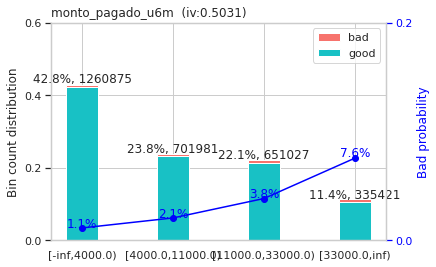

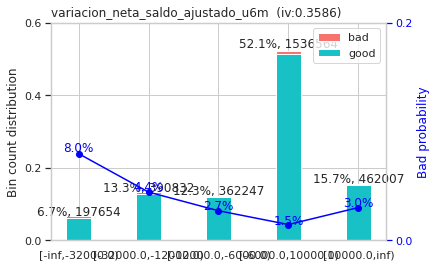

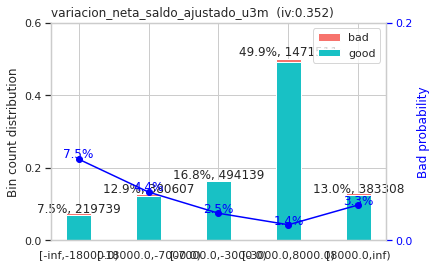

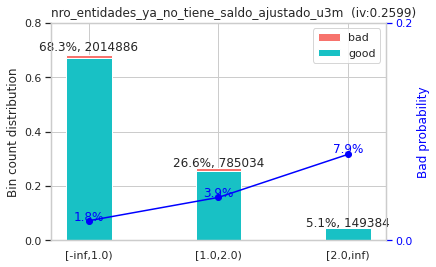

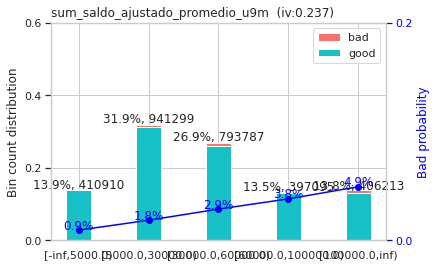

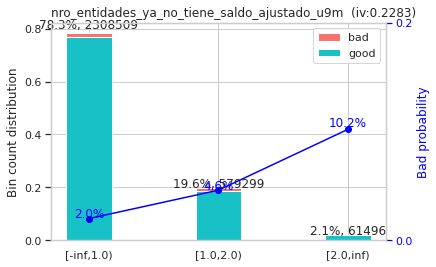

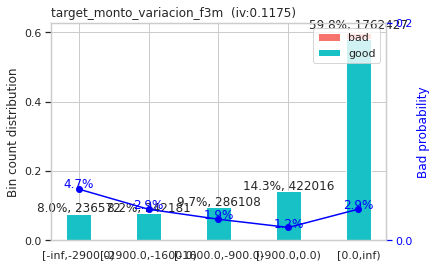

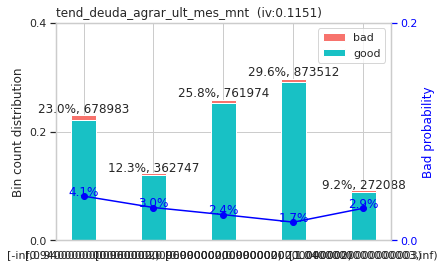

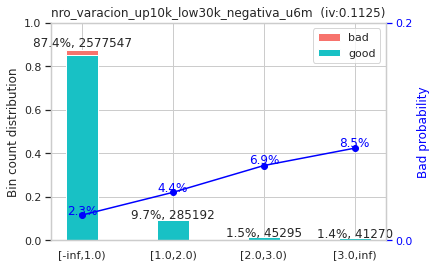

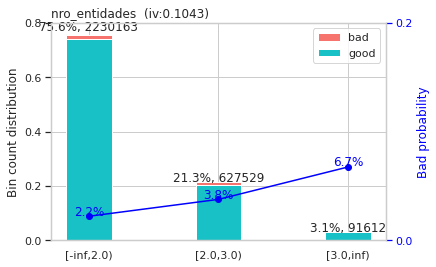

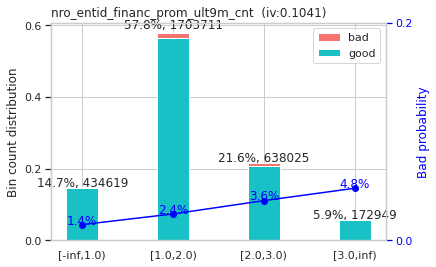

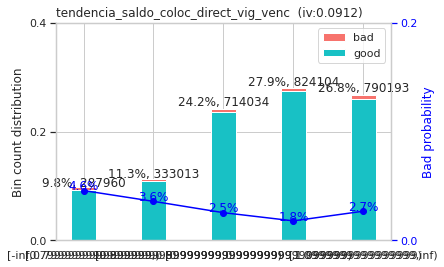

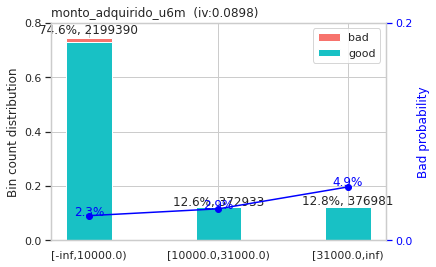

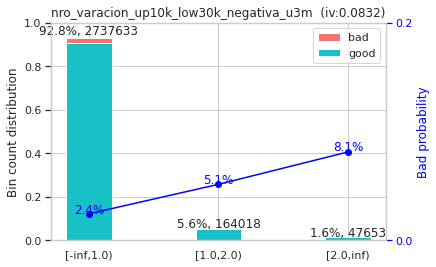

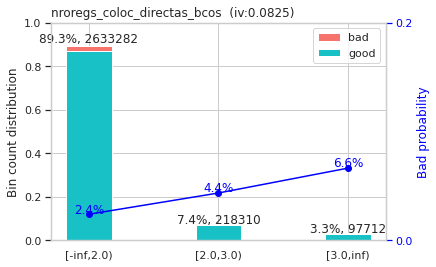

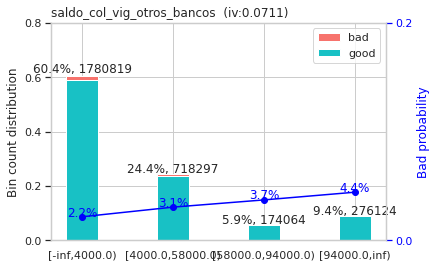

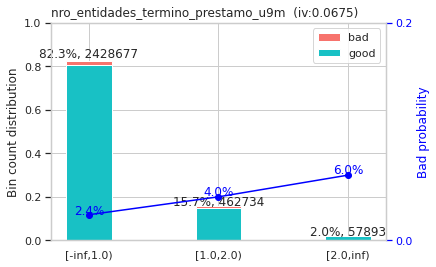

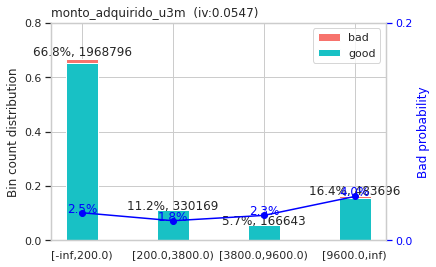

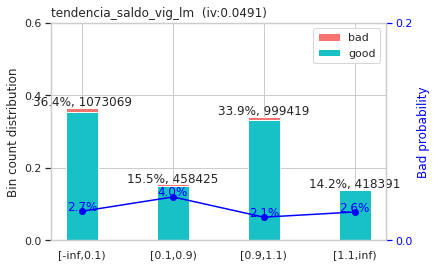

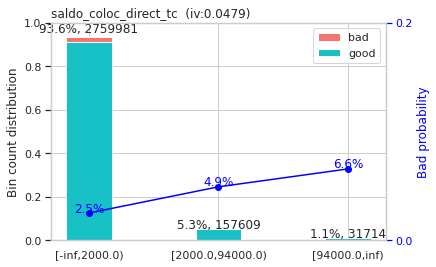

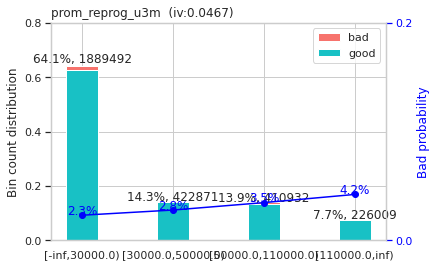

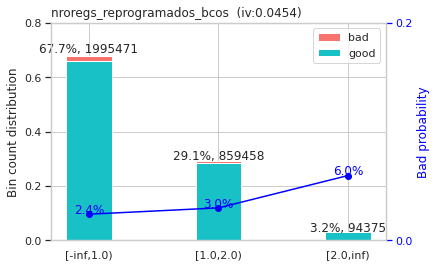

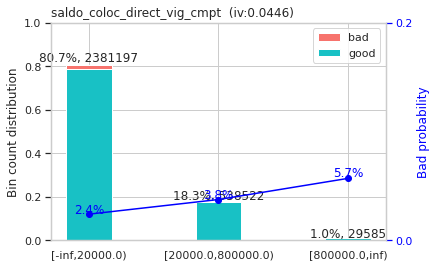

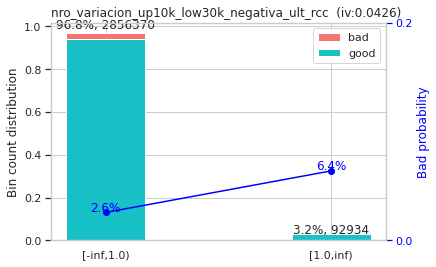

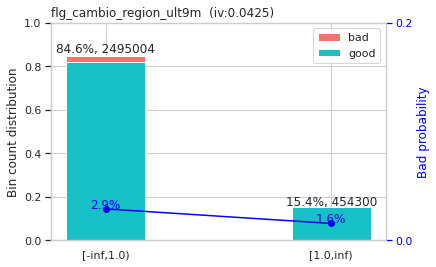

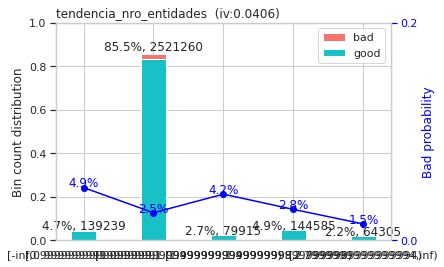

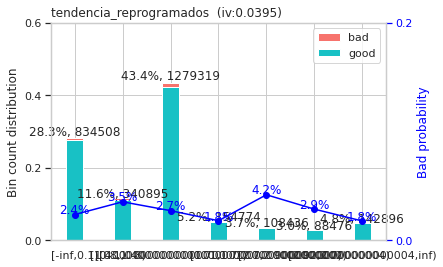

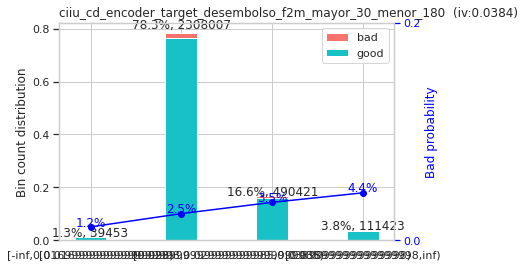

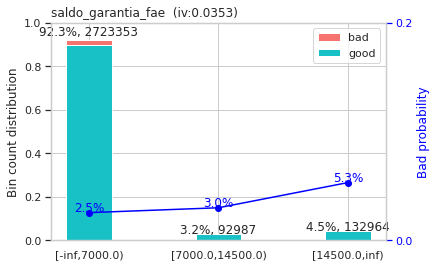

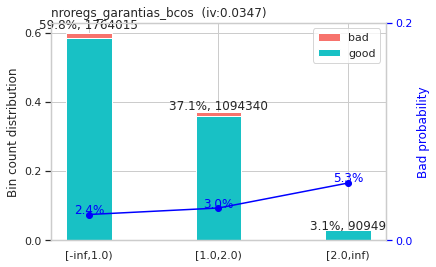

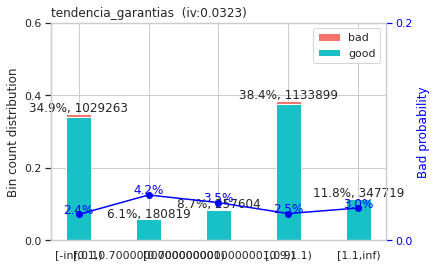

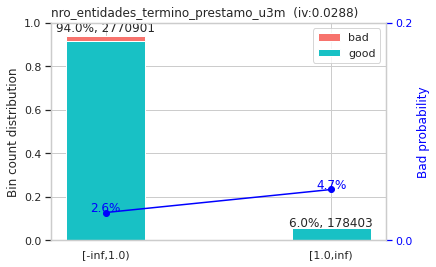

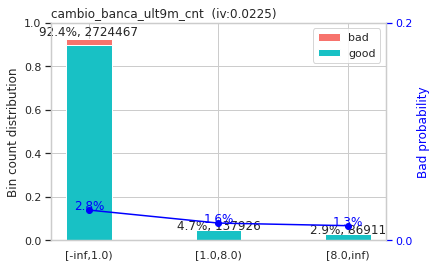

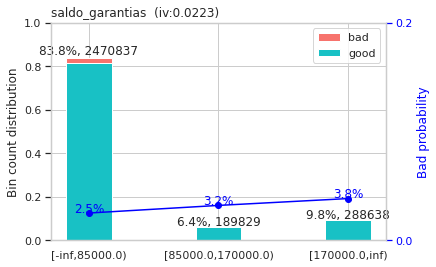

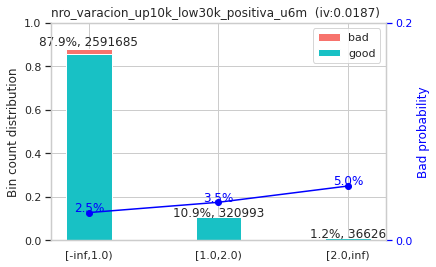

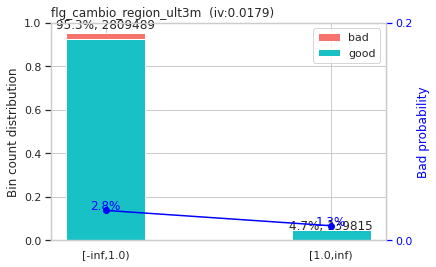

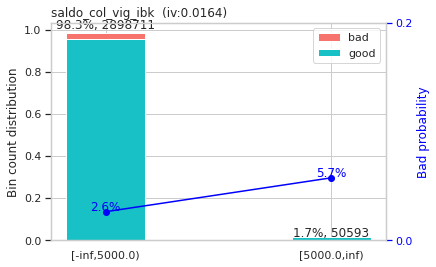

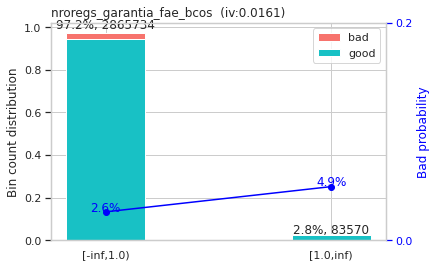

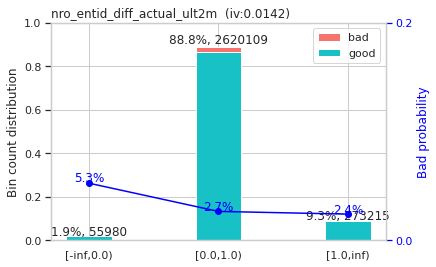

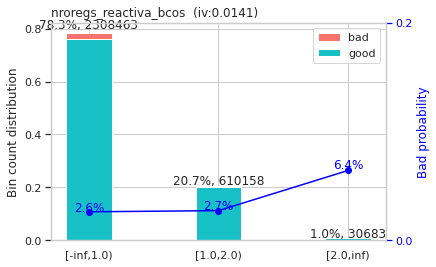

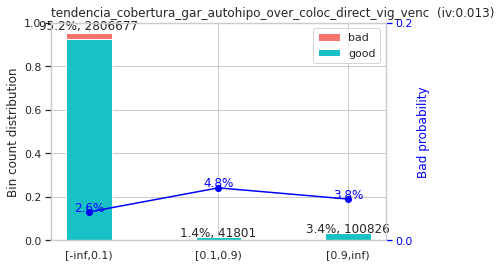

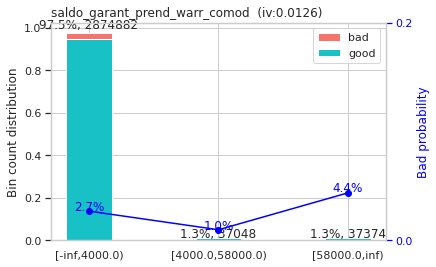

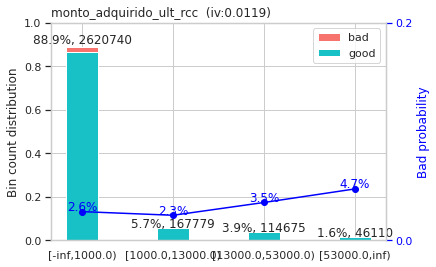

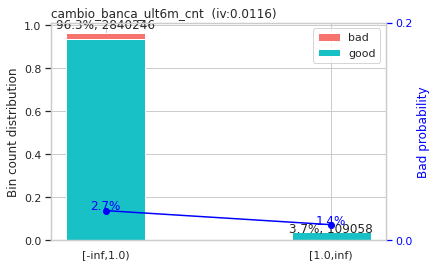

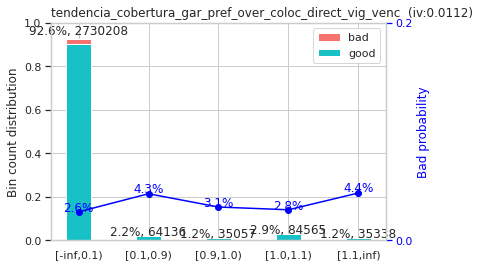

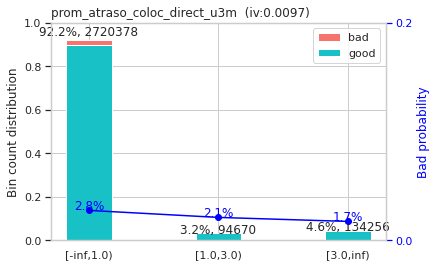

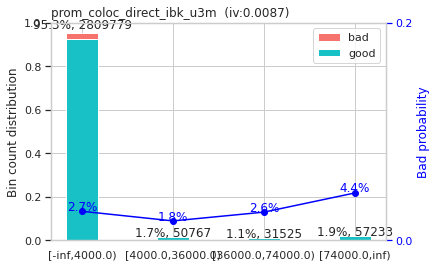

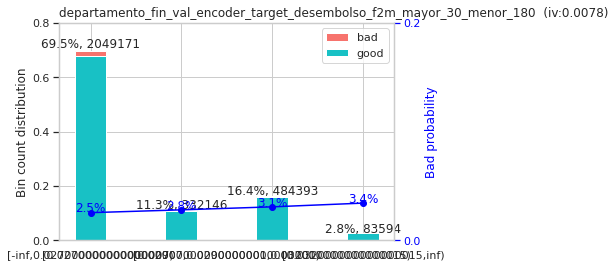

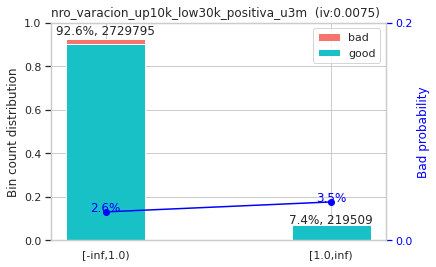

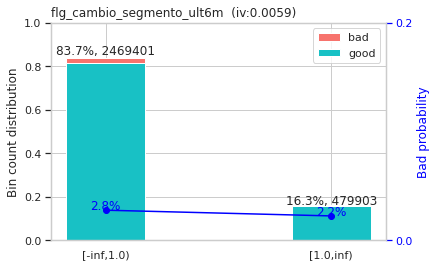

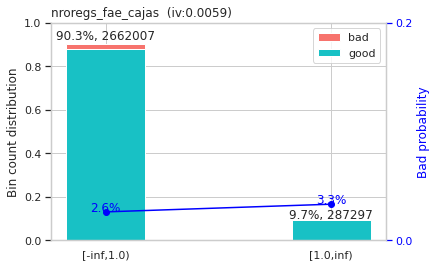

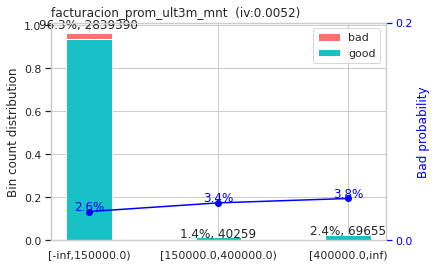

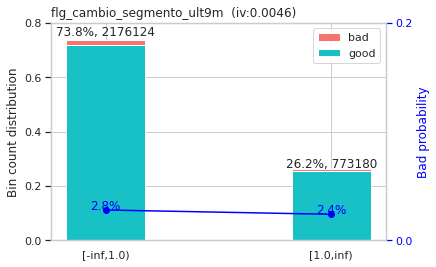

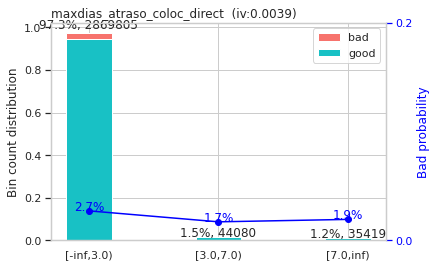

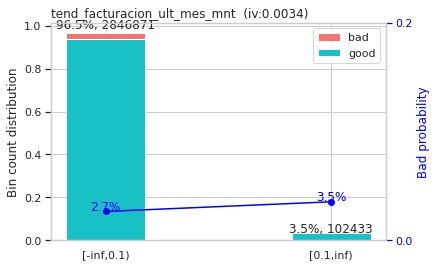

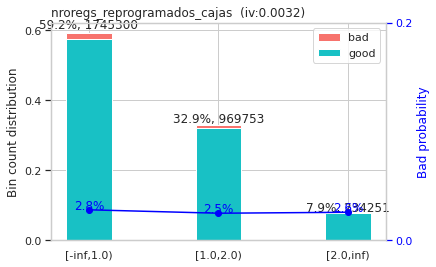

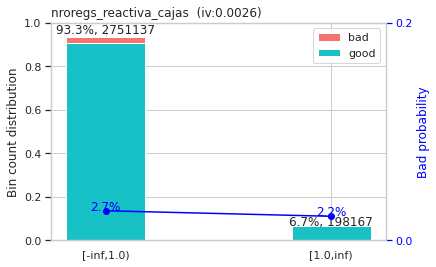

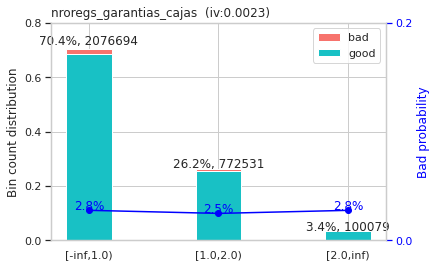

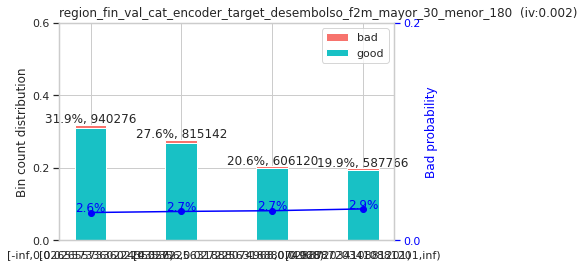

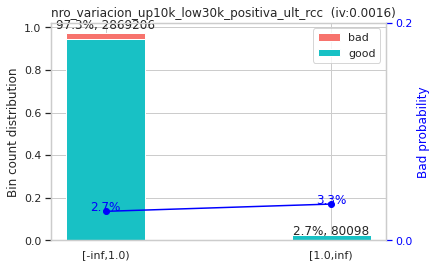

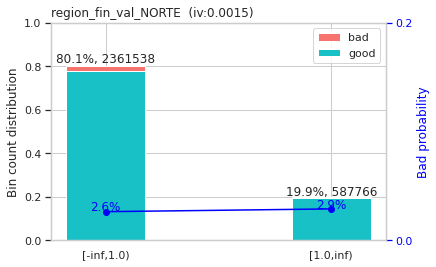

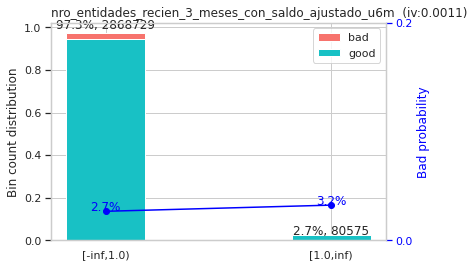

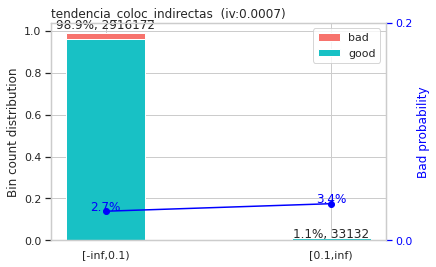

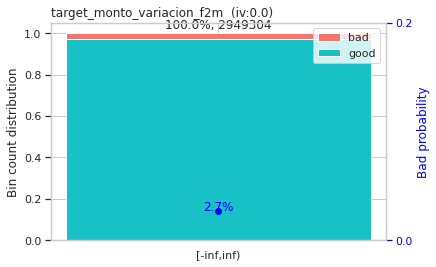

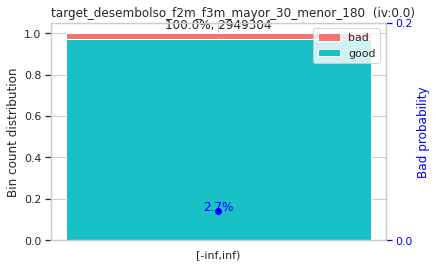

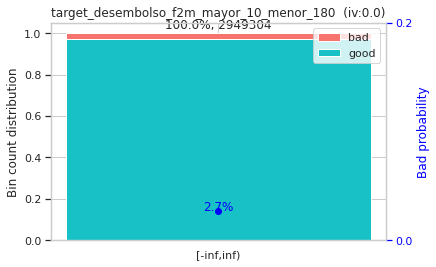

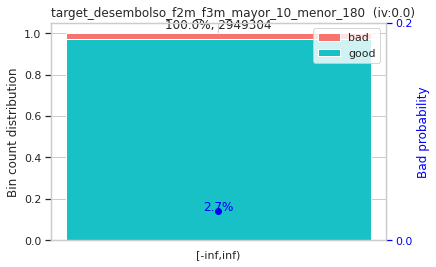

In [33]:
import scorecardpy as sc

ploteo = sc.woebin_plot(woe_dict)

In [25]:
#content_object = s3.Object('bucket', woe.split(bucket)[-1][1:])
#file_content = content_object.get()['Body'].read().decode('utf-8')
#json_content = json.loads(file_content)

In [26]:
#dupliccidad_signiicado = ['nro_entidades_ya_no_tiene_saldo_ajustado_u9m']

#descarte = [
#    'ultima_variacion_saldo_ajustado',
#    'tendencia_monto_deuda_agr_ult_mes', 'tendencia_monto_deuda_agr_utl_trim',
#    'monto_pagado_ult_rcc',  'variacion_neta_saldo_ajustado_u6m',
#  'variacion_neta_saldo_ajustado_u3m'
#]

#len(dupliccidad_signiicado), len(descarte)

In [27]:
selection = list(set([
    'monto_pagado_u6m',
    'entidad_cnt_prom_u9m',
    'ultima_variacion_saldo_ajustado',
    'entidad_cnt',
    'variacion_neta_saldo_ajustado_u3m',
    'nro_entidades_termino_prestamo_u3m',
    'monto_adquirido_u6m',
    'saldo_garantias',
    'saldo_reprogramados',
    'saldo_col_direct_vig_banco_no_ibk',
    'sum_saldo_ajustado_promedio_u9m',
    'monto_deuda_sf_prom_u9m',
    'tendencia_saldo_vig_con_lm',
    'nro_tipo_entidad',
    'nro_entidades_ya_no_tiene_saldo_ajustado_u3m'
]))

len(selection)

15

In [28]:
selection

['sum_saldo_ajustado_promedio_u9m',
 'saldo_col_direct_vig_banco_no_ibk',
 'monto_deuda_sf_prom_u9m',
 'nro_entidades_termino_prestamo_u3m',
 'tendencia_saldo_vig_con_lm',
 'saldo_garantias',
 'nro_tipo_entidad',
 'monto_adquirido_u6m',
 'monto_pagado_u6m',
 'variacion_neta_saldo_ajustado_u3m',
 'entidad_cnt',
 'nro_entidades_ya_no_tiene_saldo_ajustado_u3m',
 'ultima_variacion_saldo_ajustado',
 'entidad_cnt_prom_u9m',
 'saldo_reprogramados']